# Capstone project: The Battle of the Neighbourhoods.

### An analysis of London’s Borough of Merton to determine where’s best to situate a new Chinese restaurant.

##### Author: Colin Kagame, June 2020.

#### Importing the necessary libraries.

In [5]:
import pandas as pd # library for data analsysis
import numpy as np # # library to process data as dataframes
pd.set_option('display.max_columns', None) # library for data analsysis
pd.set_option('display.max_rows', None)

import requests # library to handle requests

import urllib.request #cols
from urllib.request import urlopen

import json  # library to handle JSON files

!pip install geopy
import geopy #cols

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# -------------- cols
import matplotlib.pyplot as plt
%matplotlib inline

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML
#--------------- cols

#import k-means from clustering stage #cols
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install beautifulsoup4
from bs4 import BeautifulSoup

from IPython.display import Image

print('Libraries imported.')

     |████████████████████████████████| 122kB 7.1MB/s eta 0:00:01
     |████████████████████████████████| 122kB 10.5MB/s eta 0:00:01
Libraries imported.


##### The libraries below are necessary to scrape the Wikepida page which is our first source of data.

In [6]:
!pip install wikipedia
!pip install lxml

import pandas as pd
import wikipedia as wp
import lxml

html = wp.page("List_of_areas_of_London").html().encode("UTF-8")
try:df = pd.read_html(html)[1] # Try 2nd table first as most pages contain contents table first
except IndexError:df = pd.read_html(html)[0]
#print(df.to_string())

df.head()

  Stored in directory: /home/jupyterlab/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia
     |████████████████████████████████| 5.5MB 7.7MB/s eta 0:00:01     |██████▍                         | 1.1MB 7.7MB/s eta 0:00:01     |█████████████████████████████▏  | 5.0MB 7.7MB/s eta 0:00:01


,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


#### As seen above, we succcessfully scraped our Wikipedia page. Now we will Rename column names to eliminate spaces.

In [7]:
# Renaming column names to eliminate spaces.

df.columns = ['Location', 'Borough', 'Town', 'Postcode', 'Dialcode' , 'OSgridref'] 

df.head()

,Location,Borough,Town,Postcode,Dialcode,OSgridref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


#### More data cleansing. Please see code comments. 

In [8]:
#Setting Town values to sentence case.
df['Town'] = df['Town'].str.title()

#Removing hyperlink and instances where there are more than one value.
df['Borough'] =  df['Borough'].apply(lambda x: x.replace('[','').replace(']','')) 
df['Borough'] =  df['Borough'].str.replace('\d+', '')
df['Borough'] =  df['Borough'].str.split(',').str[0]
df['Postcode'] =  df['Postcode'].str.split(',').str[0]
df['Postcode'] =  df['Postcode'].str.split('(').str[0]
df['Town'] =  df['Town'].str.split(',').str[0]

# Ridding of unecessary columns.
df1 = df.drop(columns=['Dialcode', 'OSgridref'])
df1.head()

,Location,Borough,Town,Postcode
0,Abbey Wood,Bexley,London,SE2
1,Acton,Ealing,London,W3
2,Addington,Croydon,Croydon,CR0
3,Addiscombe,Croydon,Croydon,CR0
4,Albany Park,Bexley,Bexley,DA5


In [9]:
#Pulling data where Borough is Merton.

df2 = df1[df1['Borough'].str.contains("Merton")]  

#df2 = df1[df1['Borough'].str.contains('Merton|Sutton')]  

df2

,Location,Borough,Town,Postcode
107,Colliers Wood,Merton,London,SW19
294,Lower Morden,Merton,Morden,SM4
305,Merton Park,Merton,London,SW19
311,Mitcham,Merton,Mitcham,CR4
313,Morden,Merton,Morden,SM4
314,Morden Park,Merton,Morden,SM4
383,Raynes Park,Merton,London,SW20
419,South Wimbledon,Merton,London,SW19
428,St Helier,Merton,Morden,SM4
520,Wimbledon,Merton,London,SW19


In [10]:
#Resetting indexes.

In [11]:
df2 = df2.reset_index(drop=True)
df2

,Location,Borough,Town,Postcode
0,Colliers Wood,Merton,London,SW19
1,Lower Morden,Merton,Morden,SM4
2,Merton Park,Merton,London,SW19
3,Mitcham,Merton,Mitcham,CR4
4,Morden,Merton,Morden,SM4
5,Morden Park,Merton,Morden,SM4
6,Raynes Park,Merton,London,SW20
7,South Wimbledon,Merton,London,SW19
8,St Helier,Merton,Morden,SM4
9,Wimbledon,Merton,London,SW19


### Getting coordinates data.

In [12]:
#Getting Merton coordinates.
!pip install geocoder

import geocoder

def get_latlng(Location):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Merton,UK'.format(Location))
        lat_lng_coords = g.latlng
    return lat_lng_coords

get_latlng('SM4')

     |████████████████████████████████| 102kB 11.0MB/s ta 0:00:01
     |████████████████████████████████| 92kB 6.6MB/s eta 0:00:011
     |████████████████████████████████| 829kB 21.3MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future


[51.392201353000075, -0.2159499999999639]

In [13]:
#COORDINATES dataframe.

#postcodes
#postal_codes = df2[['Postcode']]
#postal_codes

#list_of_postcodes = df2['Postcode'].to_list()
#print('List of Posrcodes: ', list_of_postcodes)

#coords = [ get_latlng(postal_code) for postal_code in postal_codes.tolist() ]

#coords = [ get_latlng(postal_code) for postal_code in list_of_postcodes ] #cols
#df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
#df_coords

#result = pd.concat([df2, df_coords], axis=1).reindex(df2.index)

#pd.concat([df2, df_coords], axis=1).reindex(df2.index)
#result

In [14]:
#COORDINATES dataframe.

#locations
#locations = df2[['Location']]
#locations

list_of_locations = df2['Location'].to_list()
#print('List of Postcodes: ', list_of_postcodes)

coords = [ get_latlng(location) for location in list_of_locations ] #cols
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
#df_coords

#result1 = pd.concat([df2, df_coords], axis=1).reindex(df2.index)

result1 = pd.concat([df2, df_coords], axis=1)
result1

#IF csv:
#Mertondata.to_csv('merton.csv', index=False) #  -----> csv
#Mertondata = pd.read_csv('merton.csv') #consists latitudes and longitudes.
#Mertondata.head(10) # shows the scrapped data organised into a dataframe as required.

,Location,Borough,Town,Postcode,Latitude,Longitude
0,Colliers Wood,Merton,London,SW19,51.420690,-0.175670
1,Lower Morden,Merton,Morden,SM4,51.388005,-0.209364
2,Merton Park,Merton,London,SW19,51.411418,-0.208302
3,Mitcham,Merton,Mitcham,CR4,53.796853,-3.006069
4,Morden,Merton,Morden,SM4,51.411810,-0.192434
5,Morden Park,Merton,Morden,SM4,51.411810,-0.192434
6,Raynes Park,Merton,London,SW20,51.403040,-0.207220
7,South Wimbledon,Merton,London,SW19,51.415640,-0.191420
8,St Helier,Merton,Morden,SM4,51.398485,-0.187018
9,Wimbledon,Merton,London,SW19,51.415640,-0.191420


In [15]:
#Filtering, Testing with SM4 postcodes.
#x = result[df2.Postcode == 'SM4']
#x

In [16]:
print('This area has {} boroughs and contains {} locations.'.format(
        len(df2 ['Borough'].unique()),
        df2 .shape[0]
    )
)

This area has 1 boroughs and contains 10 locations.


In [17]:
#Setting boundaries of the Map.

address = 'London, Merton'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Merton Town are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Merton Town are 51.410802849999996, -0.18809850595572736.


##### Visualising dataframe above i.e. Merton locations/neighborhoods. 

In [18]:
import folium
# creating map of Merton using latitude and longitude values
map_merton = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, borough, location in zip(result1['Latitude'], result1['Longitude'], result1['Borough'], result1['Location']):
    
    label = '{}, {}'.format(location, borough)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_merton)  
    
map_merton

In [19]:
#Lower Morden, St Helier, South Wimbledon, Morden. There are missing.

#### Utilising Foursquare to analyse locations and venues.

In [20]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [21]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = 'ZMHWBS0SR12Z3YDYVHJVTZPRK3U1ZP3I2TYQAJ5CU3JUHMB5'
CLIENT_SECRET = 'H3TT0XT3P5TIAFCV1Y2UUVLF42N44DICNKLUELK34H2TKLFR'
VERSION = '20181020'

##### Dataframe containing chinese restaurants in Merton.

In [22]:
#https://developer.foursquare.com/docs/resources/categories

neighborhoods = result1[result1['Borough'] == 'Merton'].reset_index(drop=True)
merton_venues_asian = getNearbyVenues(names=neighborhoods['Location'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d142941735')
merton_venues_asian.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Colliers Wood,51.42069,-0.17567,Thai Town,51.421436,-0.175059,Thai Restaurant
1,Colliers Wood,51.42069,-0.17567,Little Vietnam,51.415625,-0.192852,Vietnamese Restaurant
2,Colliers Wood,51.42069,-0.17567,Kaosarn,51.424663,-0.171096,Thai Restaurant
3,Colliers Wood,51.42069,-0.17567,Rosa's Thai Cafe,51.427388,-0.168848,Thai Restaurant
4,Colliers Wood,51.42069,-0.17567,Golden House,51.420179,-0.187175,Chinese Restaurant
5,Colliers Wood,51.42069,-0.17567,Confucius,51.420605,-0.163035,Chinese Restaurant
6,Colliers Wood,51.42069,-0.17567,Takahashi,51.416424,-0.192304,Sushi Restaurant
7,Colliers Wood,51.42069,-0.17567,Maki Yaki,51.418269,-0.193211,Sushi Restaurant
8,Colliers Wood,51.42069,-0.17567,Dinner King,51.426281,-0.165999,Chinese Restaurant
9,Colliers Wood,51.42069,-0.17567,Koi Ramen Bar,51.429048,-0.166357,Ramen Restaurant


In [23]:
merton_venues_asian.shape

(217, 7)

#### Visualising Asian restuarants in Merton, London.

In [24]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        
        label = folium.Popup(label, parse_html=True)
        
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [25]:
map_merton_asian = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(merton_venues_asian, 'red', map_merton_asian)

map_merton_asian

#### Number of restaurant categories per neighborhood. 

In [26]:
merton_grouped = merton_venues_asian.groupby('Neighborhood').count()
merton_grouped

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Colliers Wood,33,33,33,33,33,33
Lower Morden,5,5,5,5,5,5
Merton Park,30,30,30,30,30,30
Mitcham,3,3,3,3,3,3
Morden,36,36,36,36,36,36
Morden Park,36,36,36,36,36,36
Raynes Park,8,8,8,8,8,8
South Wimbledon,31,31,31,31,31,31
St Helier,4,4,4,4,4,4


In [27]:
print('There are {} unique categories.'.format(len(merton_venues_asian['Venue Category'].unique())))

There are 11 unique categories.


#### Chinese Restaurants.

In [28]:
#Chinese Restaurants.

neighborhoods = result1[result1['Borough'] == 'Merton'].reset_index(drop=True)
merton_venues_asian = getNearbyVenues(names=neighborhoods['Location'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d142941735')
Chinese_Rest = merton_venues_asian.loc[merton_venues_asian['Venue Category'] == "Chinese Restaurant"]
Chinese_Rest.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,Colliers Wood,51.42069,-0.17567,Golden House,51.420179,-0.187175,Chinese Restaurant
5,Colliers Wood,51.42069,-0.17567,Confucius,51.420605,-0.163035,Chinese Restaurant
8,Colliers Wood,51.42069,-0.17567,Dinner King,51.426281,-0.165999,Chinese Restaurant
13,Colliers Wood,51.42069,-0.17567,Chinese Food @ Tooting Market,51.429357,-0.167543,Chinese Restaurant
14,Colliers Wood,51.42069,-0.17567,The Kung Fu,51.415888,-0.192432,Chinese Restaurant


In [29]:
print(Chinese_Rest.shape)

(80, 7)


In [30]:
map_merton_chineseRest = folium.Map(location=[latitude, longitude], zoom_start=12)
addToMap(Chinese_Rest, 'black', map_merton_chineseRest)

map_merton_chineseRest

#### Chinese Restaurants Per Neighborhood.

In [31]:
merton_venues_asian2 = getNearbyVenues(names=neighborhoods['Location'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d145941735')
merton_venues_asian2 = merton_venues_asian2[['Neighborhood','Venue Category']]

Chinese_count = merton_venues_asian2.groupby('Neighborhood').count()
Chinese_count = Chinese_count.rename(columns={'Venue Category': 'Chinese Restaurants'})
Chinese_count


,Chinese Restaurants
Neighborhood,
Colliers Wood,14
Lower Morden,4
Merton Park,8
Mitcham,3
Morden,14
Morden Park,14
Raynes Park,4
South Wimbledon,11
St Helier,2


#### Transforming categorical data of All Asian restaurants in Merton into numeric data using one hot encoding.

In [32]:
# one hot encoding
cusines_onehot = pd.get_dummies(merton_venues_asian[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cusines_onehot['Neighborhood'] = merton_venues_asian['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cusines_onehot.columns[-1]] + list(cusines_onehot.columns[:-1])
cusines_onehot = cusines_onehot[fixed_columns]

cusines_onehot.head()

,Neighborhood,Asian Restaurant,Café,Chinese Restaurant,General Entertainment,Japanese Restaurant,Korean Restaurant,Noodle House,Ramen Restaurant,Sushi Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Colliers Wood,0,0,0,0,0,0,0,0,0,1,0
1,Colliers Wood,0,0,0,0,0,0,0,0,0,0,1
2,Colliers Wood,0,0,0,0,0,0,0,0,0,1,0
3,Colliers Wood,0,0,0,0,0,0,0,0,0,1,0
4,Colliers Wood,0,0,1,0,0,0,0,0,0,0,0


In [33]:
print(cusines_onehot.shape)

(217, 12)


#### Further grouping by Cuisine/category for each of the neighborhoods in Merton, and taking an average of the occurance frequency for each venue category.

In [34]:
merton_grouped2 = cusines_onehot.groupby('Neighborhood').mean().reset_index()
merton_grouped2

,Neighborhood,Asian Restaurant,Café,Chinese Restaurant,General Entertainment,Japanese Restaurant,Korean Restaurant,Noodle House,Ramen Restaurant,Sushi Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Colliers Wood,0.090909,0.000000,0.424242,0.030303,0.030303,0.060606,0.000000,0.030303,0.151515,0.151515,0.030303
1,Lower Morden,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000
2,Merton Park,0.133333,0.033333,0.233333,0.000000,0.166667,0.033333,0.033333,0.000000,0.133333,0.200000,0.033333
3,Mitcham,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Morden,0.083333,0.027778,0.361111,0.000000,0.111111,0.083333,0.027778,0.000000,0.111111,0.166667,0.027778
5,Morden Park,0.083333,0.027778,0.361111,0.000000,0.111111,0.083333,0.027778,0.000000,0.111111,0.166667,0.027778
6,Raynes Park,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,South Wimbledon,0.096774,0.032258,0.322581,0.000000,0.032258,0.096774,0.032258,0.000000,0.161290,0.193548,0.032258
8,St Helier,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Wimbledon,0.096774,0.032258,0.322581,0.000000,0.032258,0.096774,0.032258,0.000000,0.161290,0.193548,0.032258


#### Frequencies for each Cusine/Restuarant category in Merton, and then visualising by box plot. 

In [35]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

merton_grouped3 = merton_grouped2.drop(['Neighborhood'], axis=1) #We delete the Neighborhood column.
#merton_grouped3


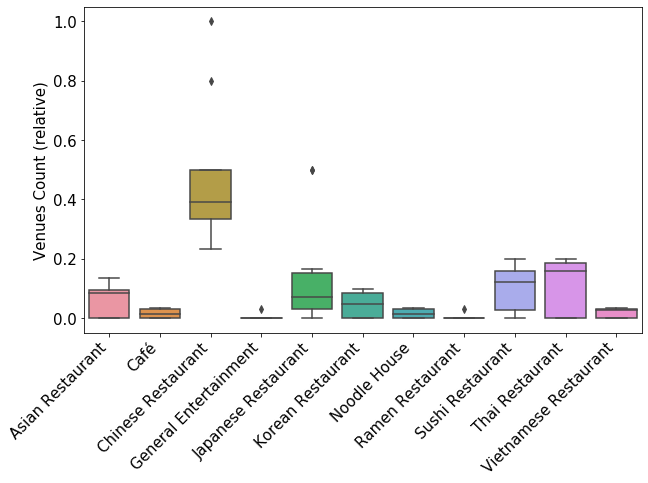

In [36]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(data = merton_grouped2)
ax.set_ylabel('Venues Count (relative)', fontsize=15)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')

plt.show()

#### Chinese restaurants.

In [37]:
# Dataframe below represents Neighbourhoods and their respective Chinese Restuarant one hot encoded values.

Chinese_Restaurants = merton_grouped2[["Neighborhood","Chinese Restaurant"]]
Chinese_Restaurants

,Neighborhood,Chinese Restaurant
0,Colliers Wood,0.424242
1,Lower Morden,0.800000
2,Merton Park,0.233333
3,Mitcham,1.000000
4,Morden,0.361111
5,Morden Park,0.361111
6,Raynes Park,0.500000
7,South Wimbledon,0.322581
8,St Helier,0.500000
9,Wimbledon,0.322581


#### Top 5, most common restaurant categories/cuisines per borough.

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#-----

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = merton_grouped2['Neighborhood']

for ind in np.arange(merton_grouped2.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(merton_grouped2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Colliers Wood,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Asian Restaurant,Korean Restaurant
1,Lower Morden,Chinese Restaurant,Sushi Restaurant,Vietnamese Restaurant,Thai Restaurant,Ramen Restaurant
2,Merton Park,Chinese Restaurant,Thai Restaurant,Japanese Restaurant,Sushi Restaurant,Asian Restaurant
3,Mitcham,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant,Ramen Restaurant
4,Morden,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Japanese Restaurant,Korean Restaurant
5,Morden Park,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Japanese Restaurant,Korean Restaurant
6,Raynes Park,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant
7,South Wimbledon,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant
8,St Helier,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant
9,Wimbledon,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Korean Restaurant,Asian Restaurant


### **CLUSTERING:** We will be using K-Mean's clustering.

In [39]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=15, random_state=8)
X = Chinese_Restaurants.drop(['Neighborhood'], axis=1)
#----------
kmeans.fit(X)
kmeans.labels_[0:10]

array([3, 2, 1, 0, 1, 1, 3, 1, 3, 1], dtype=int32)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


Text(0, 0.5, 'Error measure.')

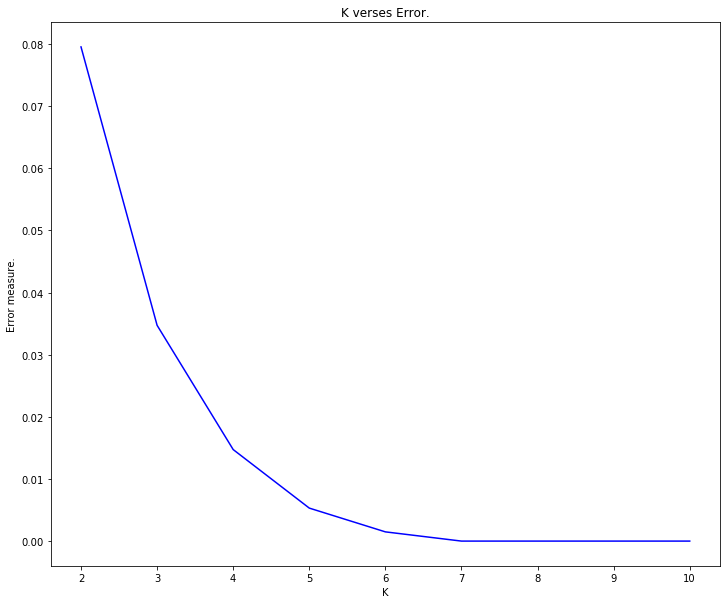

In [40]:
import seaborn as sns

def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

#------------

scores = [get_inertia(x) for x in range(2, 11)] #7 should be 11 / or 10. Errors desclines from 11 to 7. Looks like it detarmines the scale of x-axis.

#------------

plt.figure(figsize=[12, 10]) #figure plot size.

sns.lineplot(x=range(2, 11), y=scores, color='b')
plt.title("K verses Error.")
plt.xticks(range(2, 11))
plt.xlabel("K")
plt.ylabel("Error measure.")


     |████████████████████████████████| 266kB 6.7MB/s eta 0:00:01


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


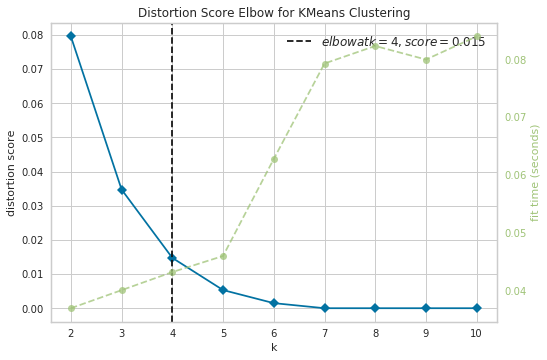

In [41]:
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(X)   
visualizer.show()  

##### As seen above on the chart, the optimum values of k is 5. (At the time of writing)

In [42]:
kclusters = 5

cuisines_grouped_clustering = Chinese_Restaurants.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cuisines_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 4, 3, 0, 0, 2, 0, 2, 0], dtype=int32)

In [43]:
#New dataframe including clusters as well as top 10 venues per neighborhood.
Chinese_merged = Chinese_Restaurants.copy()

# add clustering labels
Chinese_merged["Cluster Labels"] = kmeans.labels_
Chinese_merged

,Neighborhood,Chinese Restaurant,Cluster Labels
0,Colliers Wood,0.424242,2
1,Lower Morden,0.800000,1
2,Merton Park,0.233333,4
3,Mitcham,1.000000,3
4,Morden,0.361111,0
5,Morden Park,0.361111,0
6,Raynes Park,0.500000,2
7,South Wimbledon,0.322581,0
8,St Helier,0.500000,2
9,Wimbledon,0.322581,0


In [44]:
# Merging Merton grouped with Merton data to add latitude/longitude for each neighborhood
All_merged = Chinese_merged.join(merton_venues_asian.set_index("Neighborhood"), on="Neighborhood")

print(All_merged.shape)
All_merged.head(15)

(217, 9)


,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Thai Town,51.421436,-0.175059,Thai Restaurant
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Little Vietnam,51.415625,-0.192852,Vietnamese Restaurant
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Kaosarn,51.424663,-0.171096,Thai Restaurant
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Rosa's Thai Cafe,51.427388,-0.168848,Thai Restaurant
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Golden House,51.420179,-0.187175,Chinese Restaurant
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Confucius,51.420605,-0.163035,Chinese Restaurant
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Takahashi,51.416424,-0.192304,Sushi Restaurant
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Maki Yaki,51.418269,-0.193211,Sushi Restaurant
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Dinner King,51.426281,-0.165999,Chinese Restaurant
0,Colliers Wood,0.424242,2,51.42069,-0.17567,Koi Ramen Bar,51.429048,-0.166357,Ramen Restaurant


##### Sorting the dataframe by Cluster label.

In [45]:
print(Chinese_merged.shape)
All_merged.sort_values(["Cluster Labels"], inplace=True)
All_merged.head(25)

#Alls = All_merged.loc[All_merged['Venue Category'] == "Chinese Restaurant"]
#Alls.head(25)

(10, 3)


,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,Morden Park,0.361111,0,51.41181,-0.192434,Noodle Foodle,51.418668,-0.193499,Noodle House
5,Morden Park,0.361111,0,51.41181,-0.192434,Good Chef,51.424789,-0.188609,Chinese Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,Golden Gate,51.415295,-0.198359,Chinese Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,Yori,51.419632,-0.201439,Korean Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,Rock Star Sushi,51.413101,-0.183323,Sushi Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,Hi Bangkok,51.415034,-0.200334,Thai Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,The Kung Fu,51.415888,-0.192432,Chinese Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,Golden Place,51.419233,-0.193816,Chinese Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,China Garden,51.402986,-0.192802,Chinese Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,Gc Kitchen,51.411054,-0.209372,Chinese Restaurant


#### No. of Chinese Restaurants

In [46]:
All_merged['Venue Category'].value_counts()['Chinese Restaurant']

80

##### From dataframe count result above we learn that there are **80** Chinese Restuarants in the borough of Merton.

### Visualising our cluster groups across Merton.

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(All_merged['Venue Latitude'], All_merged['Venue Longitude'], All_merged['Neighborhood'], All_merged['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)) #Neighborhoods was Venue.
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

##### Repeating as above but filtering only Chinese restaurants.

In [48]:
Alls = All_merged.loc[All_merged['Venue Category'] == "Chinese Restaurant"]
Alls.head()

,Neighborhood,Chinese Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,Morden Park,0.361111,0,51.41181,-0.192434,Good Chef,51.424789,-0.188609,Chinese Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,Golden Gate,51.415295,-0.198359,Chinese Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,The Kung Fu,51.415888,-0.192432,Chinese Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,Golden Place,51.419233,-0.193816,Chinese Restaurant
5,Morden Park,0.361111,0,51.41181,-0.192434,China Garden,51.402986,-0.192802,Chinese Restaurant


##### Map.

In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Alls['Venue Latitude'], Alls['Venue Longitude'], Alls['Neighborhood'], Alls['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)) #Neighborhoods was Venue.
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

### **Analysing number of neighborhoods per cluster.**

In [50]:
Chinese_Restaurants["Cluster Labels"] = kmeans.labels_
Chinese_Restaurants

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Chinese Restaurant,Cluster Labels
0,Colliers Wood,0.424242,2
1,Lower Morden,0.800000,1
2,Merton Park,0.233333,4
3,Mitcham,1.000000,3
4,Morden,0.361111,0
5,Morden Park,0.361111,0
6,Raynes Park,0.500000,2
7,South Wimbledon,0.322581,0
8,St Helier,0.500000,2
9,Wimbledon,0.322581,0


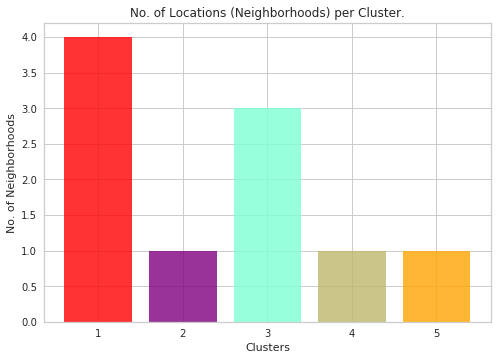

In [51]:
objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
performance = Chinese_Restaurants['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki', 'orange'])
plt.xticks(y_pos, objects)
plt.ylabel('No. of Neighborhoods')
plt.xlabel('Clusters')
plt.title('No. of Locations (Neighborhoods) per Cluster.')

plt.show()

In [52]:
# Calculating the neighborhoods in each cluster.
Chinese_Restaurants['Cluster Labels'].value_counts()

0    4
2    3
4    1
3    1
1    1
Name: Cluster Labels, dtype: int64

In [53]:
df_geo = result1[['Location', 'Borough']]
df_geo = df_geo.rename(columns={'Location': 'Neighborhood'})
df_geo

,Neighborhood,Borough
0,Colliers Wood,Merton
1,Lower Morden,Merton
2,Merton Park,Merton
3,Mitcham,Merton
4,Morden,Merton
5,Morden Park,Merton
6,Raynes Park,Merton
7,South Wimbledon,Merton
8,St Helier,Merton
9,Wimbledon,Merton


### **Analysis of Each Cluster.**

#### Cluster 1

In [54]:
#cluster1 = Alls.loc[Alls['Cluster Labels'] == 0]
cluster1 = Chinese_merged.loc[Chinese_merged['Cluster Labels'] == 0]
cluster1_df = pd.merge(df_geo, cluster1, on='Neighborhood')
cluster1_df.head()

,Neighborhood,Borough,Chinese Restaurant,Cluster Labels
0,Morden,Merton,0.361111,0
1,Morden Park,Merton,0.361111,0
2,South Wimbledon,Merton,0.322581,0
3,Wimbledon,Merton,0.322581,0


#### Cluster 2

In [55]:
cluster2 = Chinese_merged.loc[Chinese_merged['Cluster Labels'] == 1]

#cluster2 = Alls.loc[Alls['Cluster Labels'] == 1]
cluster2_df = pd.merge(df_geo, cluster2, on='Neighborhood')
cluster2_df.head()

,Neighborhood,Borough,Chinese Restaurant,Cluster Labels
0,Lower Morden,Merton,0.8,1


#### Cluster 3

In [56]:
#cluster3 = Alls.loc[Alls['Cluster Labels'] == 2]

cluster3 = Chinese_merged.loc[Chinese_merged['Cluster Labels'] == 2]
cluster3_df = pd.merge(df_geo, cluster3, on='Neighborhood')
cluster3_df.head()

,Neighborhood,Borough,Chinese Restaurant,Cluster Labels
0,Colliers Wood,Merton,0.424242,2
1,Raynes Park,Merton,0.500000,2
2,St Helier,Merton,0.500000,2


#### Cluster 4

In [57]:
#cluster4 = Alls.loc[Alls['Cluster Labels'] == 3]

cluster4 = Chinese_merged.loc[Chinese_merged['Cluster Labels'] == 3]
cluster4_df = pd.merge(df_geo, cluster4, on='Neighborhood')
cluster4_df.head()

,Neighborhood,Borough,Chinese Restaurant,Cluster Labels
0,Mitcham,Merton,1.0,3


#### Cluster 5

In [58]:
#cluster5 = Alls.loc[Alls['Cluster Labels'] == 4]

cluster5 = Chinese_merged.loc[Chinese_merged['Cluster Labels'] == 4]
cluster5_df = pd.merge(df_geo, cluster5, on='Neighborhood')
cluster5_df.head()

,Neighborhood,Borough,Chinese Restaurant,Cluster Labels
0,Merton Park,Merton,0.233333,4


##### Average number of Chinese restaurants per cluster.

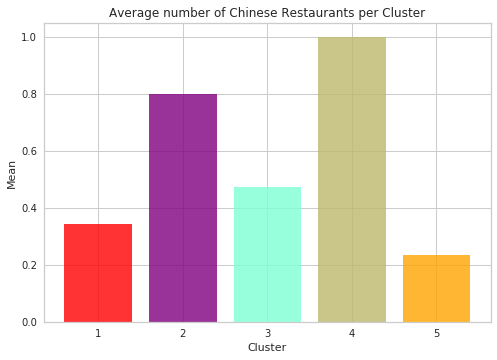

In [59]:
clusters_mean = [cluster1_df['Chinese Restaurant'].mean(),cluster2_df['Chinese Restaurant'].mean(),cluster3_df['Chinese Restaurant'].mean(),
                 cluster4_df['Chinese Restaurant'].mean(),cluster5_df['Chinese Restaurant'].mean()]

objects = (1,2,3,4,5)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki', 'orange'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Chinese Restaurants per Cluster')

plt.show()